# Обнаружение каверов музыкальных треков

**Описание проекта**

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье пользователей. Если суметь с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например:

- по желанию пользователя можно полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

Нам предлагается разработать решение, которое:

- может классифицировать треки по признаку кавер-некавер;
- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

Совсем не обязательно, чтобы наше решение умело делать все три функции. Будет уже здорово, если мы сможем придумать решение хотя бы для одной задачи.

Для решения этой задачи мы можем использовать любые открытые источники данных и собирать необходимую нам информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.

## <font size=4>**Описание данных.**

Разметка каверов

Файл `covers.json` содержит разметку каверов, сделанную редакторами сервиса:

- `track_id` - уникальный идентификатор трека;
- `track_remake_type` - метка, присвоенная редакторами. Может принимать значения `ORIGINAL` и `COVER`;
- `original_track_id` - уникальный идентификатор исходного трека.
***
Метаинформация

- `track_id` - уникальный идентификатор трека;
- `dttm` - первая дата появления информации о треке;
- `title` - название трека;
- `language` - язык исполнения;
- `isrc` - международный уникальный идентификатор трека;
- `genres` - жанры;
- `duration` - длительность трека.
***
Текст песен

- `track_id` - уникальный идентификатор трека;
- `lyricId` - уникальный идентификатор текста;
- `text` - текст трека.

***Интро:***
  в данной работе наша команда планирует создание рекомендательной системы подбора треков для пользователей одного из продуктов Яндекс.Музыка. Так как данная задача является задачей классификации, нами также будет проведено обучение и тестирование модели-классификатора.

***План выполнения работ:***
- Изучение и предварительный анализ имеющихся данных, выделение целевого признака
- Предобработка данных:
  - работа с пропусками, дубликатами
  - "очистка" и приведение к единому виду текстовых данных
- Подготовка признаков к обучению:
  - выделение предобработанных признаков из имеющегося набора
  - создание собственных признаков
  - формирование финального набора признаков
- Обучение и валидация модели на сформированном наборе признаков
- Создание алгоритма рекомендательной системы подбора треков для конечного пользователя.

## Библиотеки и загрузки

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix)
import re
import difflib

In [ ]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_color_codes(palette='pastel')
sns.set_palette('pastel', n_colors=10)

In [ ]:
!pip3 install catboost
from catboost import CatBoostClassifier

In [ ]:
try:
    covers = pd.read_json('/content/covers.json', lines=True)
except:
    covers = pd.read_json('/Users/maiiayakusheva/Downloads/data/covers.json', lines=True)

In [ ]:
try:
    lyrics = pd.read_json('/content/lyrics.json', lines=True)
except:
   lyrics = pd.read_json('/Users/maiiayakusheva/Downloads/data/lyrics.json', lines=True)

In [ ]:
try:
    meta = pd.read_json('/content/meta.json', lines=True)
except:
    meta = pd.read_json('/Users/maiiayakusheva/Downloads/data/meta.json', lines=True)

## Анализ датасетов

### Анализ датасета Covers

In [ ]:
covers.sample(15)

,original_track_id,track_id,track_remake_type
63572,None,424757f905b8af0b54e744b8e274a61c,COVER
40672,None,1ee9b592fe283eb8217d8cb5e0874d25,COVER
70567,06d02586145c65f623bbe964ec2210a9,06d02586145c65f623bbe964ec2210a9,ORIGINAL
50986,None,e362f7452315d4d3dc7a17eefcb6b9ae,COVER
6278,None,bf1546283da21c9c087bda5d1131921d,COVER
4226,17d7017dc7c7209af086203723776436,17d7017dc7c7209af086203723776436,ORIGINAL
46187,None,5583173bb76b2c6751734e5aebdb2ef5,COVER
8879,580e412ca0bb46b47fa2dd32507d1171,580e412ca0bb46b47fa2dd32507d1171,ORIGINAL
8413,2bf44a6779e1ca1371ea6ab36f0fbd29,2bf44a6779e1ca1371ea6ab36f0fbd29,ORIGINAL
62841,None,2ada153ce9afa488fba7677255f96872,COVER


In [ ]:
covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [ ]:
covers['track_remake_type'].value_counts()

COVER       67304
ORIGINAL     4293
Name: track_remake_type, dtype: int64

In [ ]:
covers['original_track_id'].isna().sum()

66776

In [ ]:
miss = []
dupl = []
for i in covers.columns:
    miss.append(covers[i].isna().sum())
    dupl.append(covers[i].nunique())



miss_df = pd.DataFrame({'name' : covers.columns, 'NaN' : miss, 'Unique' : dupl})
miss_df

,name,NaN,Unique
0,original_track_id,66776,4468
1,track_id,0,71597
2,track_remake_type,0,2


**Вывод:** В датасете corvers содержится 71597 строк в 3 колонках. Тип всех данных строковый, присутствуют 66776 пропусков в столбце с id уникального трека(все пропуски относятся к значению столбца с метками COVER), соотвественно в данных практически нет соотнесения оригинальных треков и каверов. Также в данном датасете присутствует целевой признак - track_remake_type

Значения в колонке track_id все уникальные

### Анализ датасета Lyrics

In [ ]:
lyrics.sample(15)

,lyricId,text,track_id
2840,ac88c603f9051c4c4948528b950d8d41,Mommy don't know daddy's getting hot\nAt the b...,ec93324900d50e60290b3199372cd226
9862,7bddbc533366fa9f52ca28f43bc714d7,Sometimes I feel like throwing my hands up in ...,5b145756dabdc3ed89ed0e49dc0163c4
7013,db43fa3c9d6c9b1bdfe70d01f5f711a7,Let's go\nSteve walks warily down the street\n...,a0594d86cbae168e895929cd7ad81fcc
2587,945029b79dad0c29dc1585be045e2c18,"Skies are crying, I am watching\nCatching tear...",d1102f4217205118bef277f0f7a235f7
2793,103ddc6df49793638e3ee554a9b13d67,"Говорил Бог: ""Не смей убивать""\nЭто наша земля...",96502167fdfa366f576f3b978ffa8638
1491,d420f6ed04058fee9dc6ee0582e69d88,Потаённые дебри души\nЗакопали на забытых\nПро...,b73e8c90df04cea4eb22ba943d5dd409
1114,908e0dc0a65025e756bed43310f539c7,"DJ Tape\n\nСука, get low\nОна мне дала, ведь е...",6d819bfd7dece57a158981b8ee96220f
9712,4f5ab4f33ff87fd428fa3628e59705e4,Took a ride to the end of the line\nWhere no o...,cbc6c831cfe3e21448070ba99b41d3fa
2508,063e4e04c3ca198fc0fcc79ffd5eddd1,(It starts with one)\nOne thing I don't know w...,dfac65053b8c4b264c8a485fbcd0af82
10051,f24b9cb93f73154e33210957140191c5,The kisses of the sun were sweet\nI didn't bli...,3ce251e32db2f728040e976c5b8c89a6


In [ ]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


In [ ]:
lyrics['track_id'].value_counts()

b891000882f4a612190142861b5c038b    24
adc126c946551da4e1784e716b77992e    17
f0f429d03fdd19f08ff60e889e32aae2    16
951edd96627f47b783716a54d2368d7b    12
ca1c4cbc9b1cb3197ed5e52df9caf573    12
                                    ..
f4d64771c9859a7c24c9fd4e513b0173     1
044c9caa72f85c15f0e4cde5d1906957     1
1baad2f02b10ae48aa0457386ef7c3fe     1
32436073f567a7afd699bb9261c89b51     1
c860754a50dac664d847bca85e6897f4     1
Name: track_id, Length: 10277, dtype: int64

In [ ]:
lyrics.duplicated().sum()

0

In [ ]:
miss = []
dupl = []
for i in lyrics.columns:
    miss.append(lyrics[i].isna().sum())
    dupl.append(lyrics[i].nunique())



miss_df = pd.DataFrame({'name' : lyrics.columns, 'NaN' : miss, 'Unique' : dupl})
miss_df['Duplicates'] = 11414 - miss_df['Unique']
miss_df

,name,NaN,Unique,Duplicates
0,lyricId,0,10915,499
1,text,0,10644,770
2,track_id,0,10277,1137


**Вывод**: В датасете lyrics содержится 11414 строки. Пропуски в данных отсутствуют, однако имеется много повторов. Так в поле текст содержится 10644 уникальных записи и 770 дубликатов. В лирик id 10915 уникальных записей и 499 дубликатов, track_id имеет 10277 уникальных номера и 1137 повторов.

In [ ]:
lyrics.loc[(lyrics['track_id'] == 'b891000882f4a612190142861b5c038b')]

,lyricId,text,track_id
1800,6510c50bec7a64a02a3a198793d81f2b,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
1814,5de2a48ffe755a226704bb6db2f1b743,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
3360,89d690b2da9a4827cfd9f1fa088ec207,"La, la, la, la, la, la, la, la, la, la, la, la...",b891000882f4a612190142861b5c038b
5304,1a6450a439b4d385b40f3077d308e01a,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6007,3aa4b1682c24f8ce982245856da157d6,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6175,5fdc9a316a05bca8a5d6b1d5da453659,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6535,66183e0ff8df93904f9f67b63e6980d9,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
7595,11ba6102483116158e814fcc7bbdc55e,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
7601,504c9590913941d22dd49124f63d4d5e,La lalala lala lalala lala\nLa lalala lala lal...,b891000882f4a612190142861b5c038b
7602,913ae25eda32c1b63d180562d65fade2,La lalala lala lalala lala\nLa lalala lala lal...,b891000882f4a612190142861b5c038b


**Вывод:** В текстах песен есть как полные повторы, так и тексты отличающиеся - знаками препинаний, количеством повторов припева, где-то есть различия в текстах.
Полные дубли я приняла решение сразу удалить.
Для анализа в дальнейшем не нужна будет колонка lyricId

In [ ]:
lyrics = lyrics.drop('lyricId', axis=1)
lyrics.shape

(11414, 2)

In [ ]:
lyrics.duplicated().sum()

264

In [ ]:
lyrics = lyrics.drop_duplicates()
lyrics.shape

(11150, 2)

In [ ]:
lyrics.loc[(lyrics['track_id'] == 'b891000882f4a612190142861b5c038b')]

,text,track_id
1800,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
1814,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
3360,"La, la, la, la, la, la, la, la, la, la, la, la...",b891000882f4a612190142861b5c038b
6175,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6535,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
7601,La lalala lala lalala lala\nLa lalala lala lal...,b891000882f4a612190142861b5c038b
9004,"La, la, la, la, la, la, la\nLa, la, la, la, la...",b891000882f4a612190142861b5c038b


In [ ]:
count_dup = lyrics['track_id'].value_counts().to_frame()
count_dup['track_id'].value_counts()

1     9693
2      426
3       90
4       34
5       19
7        6
6        6
8        2
10       1
Name: track_id, dtype: int64

**Вывод:** В датасете лирик большая часть песен встречается 1 раз - 9693 треков. 1457 текстов относятся к повторяющимся track_id

### Анализ датасета Meta

In [ ]:
meta.sample(15)

,track_id,dttm,title,language,isrc,genres,duration
37472,33db9abcc12860ac1630ebc9f5d70e97,1.634699e+12,Bonita,None,QZNJW2109059,[FOLK],189250.0
32624,867d5e3e04e0074896c66b6c24994065,1.630613e+12,Quando Eu For Embora,None,QZNJV2196899,"[FOLK, LATINFOLK]",178670.0
1174,97fbb323afbbcd2ef8bb279d8293ff5c,1.638892e+12,Suna Hai,None,QZTPX2139501,[POP],167100.0
18967,2d1e5ff2662ba2bf01ab534fa3dfd73a,1.639516e+12,I Don'T Like You,EN,ZAC012000037,[POP],193000.0
49406,0294d2b3707561d6d4fc9c1df122de5f,1.404245e+12,Ass Back Home,None,USCRP1200083,[POP],224710.0
9602,9fd9e760685a0965011cea06d9cdba1b,1.651109e+12,Verdadeiro Amor,None,QZHZ52227382,"[FOLK, LATINFOLK]",194000.0
32368,d14556706bcdb63d86128f6756050839,1.630519e+12,A los Cuatro Vientos,None,QZNJV2186929,"[FOLK, LATINFOLK]",170370.0
21280,3392c943ea5b9a819e5848b998ed740d,1.619399e+12,Milonga de Pelo Largo,None,QZHZ32173417,"[ROCK, ALLROCK]",276480.0
20745,c52cdeeb5d2793abc2b1f445164b9c9a,1.618619e+12,Drankin N Smokin,EN,USLZJ2143912,[RAP],0.0
37203,f9a8595d06003f7e1d24c7f969303f6f,1.634557e+12,Voce Nao Vai Parar,None,QZNJX2148466,"[JAZZ, CONJAZZ]",242440.0


In [ ]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


In [ ]:
meta.describe(include='all')

,track_id,dttm,title,language,isrc,genres,duration
count,71768,7.176800e+04,71768,21969,71455,71768,7.176800e+04
unique,71768,NaN,45462,85,71283,232,NaN
top,c3b9d6a354ca008aa4518329aaa21380,NaN,Morena,EN,USTCF1018560,"[FOLK, LATINFOLK]",NaN
freq,1,NaN,81,15322,3,18391,NaN
mean,NaN,1.584287e+12,NaN,NaN,NaN,NaN,2.049187e+05
std,NaN,9.113923e+10,NaN,NaN,NaN,NaN,8.559854e+04
min,NaN,1.249926e+12,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,1.570141e+12,NaN,NaN,NaN,NaN,1.613700e+05
50%,NaN,1.620405e+12,NaN,NaN,NaN,NaN,1.993950e+05
75%,NaN,1.637050e+12,NaN,NaN,NaN,NaN,2.390700e+05


In [ ]:
meta['isrc'].value_counts().sort_values()

QZNJY2034152    1
QZNJZ2175511    1
QZNJZ2175512    1
QZNJZ2175513    1
QZNJZ2176579    1
               ..
INUM70900046    2
USM951900014    2
FR33T0819525    3
USTCF1017794    3
USTCF1018560    3
Name: isrc, Length: 71283, dtype: int64

In [ ]:
meta['track_id'].duplicated().sum()

0

In [ ]:
meta['language'].value_counts()

EN    15322
ES     1747
RU     1558
IT      907
HI      285
      ...  
BM        1
TN        1
AB        1
NY        1
IU        1
Name: language, Length: 85, dtype: int64

In [ ]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


In [ ]:
meta.tail(15)

,track_id,dttm,title,language,isrc,genres,duration
71754,51d53b670205158abd2eb266fd44c50b,1.560227e+12,B.O.P.,None,QZGLM1908253,[PUNK],123430.0
71755,6bc5b6d04b1a96089ffe677440e059ec,1.560227e+12,Police Story,None,QZGLM1908256,[PUNK],133120.0
71756,5708c1851ae25d75038fe1522009eeca,1.560270e+12,El Angel Que Quiero Yo,None,QZGLM1906110,"[FOLK, LATINFOLK]",227190.0
71757,74e0e689408fe2449a70490dbfe7011e,1.560278e+12,Laços de Amor,None,QZGLM1907749,[SPIRITUAL],259000.0
71758,a95d976c7342f213a2d50a8c9d6c32a8,1.560281e+12,High Hopes,None,ES71G1408071,"[ROCK, ALLROCK]",582860.0
71759,27338fa59732e7b6a6f89ea3e9cf7611,1.560281e+12,Little Wing,None,ES71G1408072,"[ROCK, ALLROCK]",190320.0
71760,e3899173fcdfbd30ff0b07c7e0dbdbc8,1.561064e+12,Shutter Island,None,CAB391902526,[ALTERNATIVE],206650.0
71761,86f1aff8c191baf6957fcda82fe6b3c3,1.560892e+12,Diamonds,None,ES50A1900470,"[ELECTRONICS, HOUSE]",281980.0
71762,495babc700c0c6b5b8549d49f163d3cb,1.625346e+12,Stay With Me,EN,GBKPL1955058,"[JAZZ, VOCALJAZZ]",152090.0
71763,496e3bddf448fbedab6a0825382618c4,1.560399e+12,Se Preparó,None,FR2X41997633,"[FOLK, LATINFOLK]",186340.0


In [ ]:
meta = meta.dropna(subset=['track_id'], axis=0)

Открыт датасет meta, содержащий 71769 строк и 3 столбца с данными(2 из которых имеют численный и 5 строковый тип данных), в данных присутствуют пропуски: в значительном количестве в данных об языке исполнения(49800), 314 строк пропущены в международном ID трека, также присутствует одна абсолютно пустая строка(44434), она будет удалена

#### Разбираемся с жанрами.

В колонке genres - жанры, все строки заполнены, при этом 232 уникальных значения, однако есть переечения по смыслу и количество уникальных жанров имеет смысл сократить.

In [ ]:
meta['genres'].value_counts()

[FOLK, LATINFOLK]                     18391
[POP]                                 13157
[ROCK, ALLROCK]                        5898
[ALTERNATIVE]                          3570
[FOLK]                                 2645
                                      ...  
[BOOKSNOTINRUSSIAN]                       1
[POP, SPIRITUAL]                          1
[BLUES, RAP]                              1
[FOLK, FOREIGNRAP, RAP, LATINFOLK]        1
[ROCK, ALLROCK, FOLKGENRE]                1
Name: genres, Length: 232, dtype: int64

In [ ]:
#meta = meta.explode('genres')
#meta.head()

In [ ]:
# Функция для преобразования списка в строку
def list_to_string(genre_list):
    if genre_list is not None:
        str_list = [str(genre) for genre in genre_list]
        return ', '.join(str_list)
    else:
        return ''

In [ ]:
# преобразуем список значений в meta['genres'] в строку
meta['genres'] = meta['genres'].apply(list_to_string)
meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,DANCE,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,ELECTRONICS,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"FOLK, LATINFOLK",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"FOLK, LATINFOLK",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"FOLK, LATINFOLK",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,INDIE,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,POP,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,ALTERNATIVE,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,ALTERNATIVE,251010.0


In [ ]:
meta['genres'].nunique()

232

In [ ]:
# объединяем все строки в Series в одну строку, разделенную запятыми
genre_string = meta['genres'].str.cat(sep=',')
# разделение строки по запятым
genre_list = genre_string.split(',')
# удаление пробелов и преобразование в нижний регистр
cleaned_genres = [genre.strip().lower()
                  for genre in genre_list if genre.strip()]
# преобразование в множество для уникальности и обратное преобразование в список
unique_genres = list(set(cleaned_genres))
# сортировка списка по алфавиту
unique_genres.sort()
# считаем количество уникальных жанров
num_genres = len(unique_genres)
print(f"Количество жанров: {num_genres}")
# вывод уникальных жанров, отсортированных по алфавиту
unique_genres

Количество жанров: 128


['african',
 'allrock',
 'alternative',
 'alternativemetal',
 'ambientgenre',
 'amerfolk',
 'animated',
 'animemusic',
 'arabesquemusic',
 'arabicpop',
 'asiapop',
 'azerbaijanpop',
 'balkan',
 'bard',
 'bassgenre',
 'bebopgenre',
 'bigbands',
 'blackmetal',
 'blues',
 'bollywood',
 'booksnotinrussian',
 'breakbeatgenre',
 'caucasian',
 'celtic',
 'children',
 'classical',
 'classicalmasterpieces',
 'classicalmusic',
 'classicmetal',
 'conjazz',
 'country',
 'dance',
 'deathmetal',
 'disco',
 'dnb',
 'doommetal',
 'dub',
 'dubstep',
 'eastern',
 'edmgenre',
 'electronics',
 'epicmetal',
 'estrada',
 'eurofolk',
 'experimental',
 'extrememetal',
 'fairytales',
 'films',
 'folk',
 'folkgenre',
 'folkmetal',
 'folkrock',
 'forchildren',
 'foreignbard',
 'foreignrap',
 'funk',
 'gothicmetal',
 'hardcore',
 'hardrock',
 'house',
 'hyperpopgenre',
 'idmgenre',
 'indie',
 'industrial',
 'israelipop',
 'israelirock',
 'japanesepop',
 'jazz',
 'jewish',
 'kpop',
 'latinfolk',
 'local-indie',
 '

In [ ]:
# Приводим значения столбца 'genres' к нижнему регистру и удаляем пробелы
meta['genres'] = meta['genres'].str.replace(' ', '').str.lower()
meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,dance,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,electronics,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"folk,latinfolk",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"folk,latinfolk",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"folk,latinfolk",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,indie,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,pop,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,alternative,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,alternative,251010.0


In [ ]:
# объединяем все строки в Series в одну строку, разделенную запятыми
genre_string = meta['genres'].str.cat(sep=',')
# разделение строки по запятым
genre_list = genre_string.split(',')
# удаление пробелов и преобразование в нижний регистр
cleaned_genres = [genre.strip().lower()
                  for genre in genre_list if genre.strip()]
# преобразование в множество для уникальности и обратное преобразование в список
unique_genres = list(set(cleaned_genres))
# сортировка списка по алфавиту
unique_genres.sort()
# считаем количество уникальных жанров
num_genres = len(unique_genres)
print(f"Количество жанров: {num_genres}")
# вывод уникальных жанров, отсортированных по алфавиту
unique_genres

Количество жанров: 128


['african',
 'allrock',
 'alternative',
 'alternativemetal',
 'ambientgenre',
 'amerfolk',
 'animated',
 'animemusic',
 'arabesquemusic',
 'arabicpop',
 'asiapop',
 'azerbaijanpop',
 'balkan',
 'bard',
 'bassgenre',
 'bebopgenre',
 'bigbands',
 'blackmetal',
 'blues',
 'bollywood',
 'booksnotinrussian',
 'breakbeatgenre',
 'caucasian',
 'celtic',
 'children',
 'classical',
 'classicalmasterpieces',
 'classicalmusic',
 'classicmetal',
 'conjazz',
 'country',
 'dance',
 'deathmetal',
 'disco',
 'dnb',
 'doommetal',
 'dub',
 'dubstep',
 'eastern',
 'edmgenre',
 'electronics',
 'epicmetal',
 'estrada',
 'eurofolk',
 'experimental',
 'extrememetal',
 'fairytales',
 'films',
 'folk',
 'folkgenre',
 'folkmetal',
 'folkrock',
 'forchildren',
 'foreignbard',
 'foreignrap',
 'funk',
 'gothicmetal',
 'hardcore',
 'hardrock',
 'house',
 'hyperpopgenre',
 'idmgenre',
 'indie',
 'industrial',
 'israelipop',
 'israelirock',
 'japanesepop',
 'jazz',
 'jewish',
 'kpop',
 'latinfolk',
 'local-indie',
 '

In [ ]:
# Функция для удаления части из каждой строки в столбце.
def remove_part(df, word):
    # Функция для обработки каждого значения жанра
    def clean_genre(genre):
        # Разделяем значение жанра на части
        parts = genre.split()
        # Создаем новый список
        filtered_parts = []
        for part in parts:
            # Проверяем, содержится ли заданная часть в текущей части
            if word in part:
                # Удаляем заданную часть, заменяя ее пустой строкой
                new_part = part.replace(word, '')
                # Проверяем, начинается ли новая часть со знака запятой
                if new_part.startswith(','):
                    # Если да, удаляем запятую, отсекая первый символ
                    new_part = new_part[1:]
                # Добавляем обновленную часть в список
                filtered_parts.append(new_part)
            else:
                # Если заданная часть не найдена, добавляем текущую часть без изменений
                filtered_parts.append(part)
# Объединяем обновленные части в одну строку с пробелами, если они существуют, иначе возвращаем пустую строку
        return ' '.join(filtered_parts) if filtered_parts else ''

    updated_genres = df['genres'].apply(clean_genre)
    df['genres'] = updated_genres
    return df

In [ ]:
remove_part(meta, 'latin')
remove_part(meta, 'rus')
remove_part(meta, 'turkish')
remove_part(meta, 'uzbek')
remove_part(meta, 'asia')
remove_part(meta, 'azerbaijan')
remove_part(meta, 'azerbaijan')
remove_part(meta, 'euro')
remove_part(meta, 'foreign')
remove_part(meta, 'israeli')
remove_part(meta, 'japanese')
remove_part(meta, 'uk')
remove_part(meta, 'amer')
remove_part(meta, 'trad')
remove_part(meta, 'arabic')

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,dance,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,electronics,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"folk,folk",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"folk,folk",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"folk,folk",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,indie,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,pop,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,alternative,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,alternative,251010.0


In [ ]:
# Функция для замены части из каждого значения в столбце
def remove_from_df(df, word, replacement):
    # Функция для обработки каждого значения жанра
    def clean_genre(genre):
        # Разделяем значение жанра на отдельные части
        parts = genre.split()
        # Создаем пустой список
        updated_parts = []
        # Итерируемся по каждой части
        for part in parts:
            # Проверяем, содержание
            if word in part:
                # Заменяем
                new_part = part.replace(word, replacement)
                # Добавляем обновленную часть в список обновленных частей
                updated_parts.append(new_part)
            else:
                # Если нет изменений, добавляем без изменений
                updated_parts.append(part)
                # Объединяем обновленные части
        return ' '.join(updated_parts) if updated_parts else ''

    updated_genres = df['genres'].apply(clean_genre)
    df['genres'] = updated_genres

    return df

In [ ]:
remove_from_df(meta, 'bards', 'bard')
remove_from_df(meta, 'classicalmasterpieces', 'classical')
remove_from_df(meta, 'classicalmusic', 'classical')
remove_from_df(meta, 'dub', 'dubstep')
remove_from_df(meta, 'folkgenre', 'folk')
remove_from_df(meta, 'forchildren', 'children')
remove_from_df(meta, 'poemsforchildren', 'children')
remove_from_df(meta, 'poemschildren', 'children')
remove_from_df(meta, 'local-indie', 'indie')
remove_from_df(meta, 'reggaeton', 'reggae')
remove_from_df(meta, 'rrock', 'rock')
remove_from_df(meta, 'tvseries', 'soundtrack')
remove_from_df(meta, 'films', 'soundtrack')
remove_from_df(meta, 'dubstepstep', 'dubstep')
remove_from_df(meta, 'allrock', 'rock')

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,dance,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,electronics,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"folk,folk",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"folk,folk",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"folk,folk",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,indie,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,pop,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,alternative,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,alternative,251010.0


In [ ]:
# объединяем все строки в Series в одну строку, разделенную запятыми
genre_string = meta['genres'].str.cat(sep=',')
# разделение строки по запятым
genre_list = genre_string.split(',')
# удаление пробелов и преобразование в нижний регистр
cleaned_genres = [genre.strip().lower()
                  for genre in genre_list if genre.strip()]
# преобразование в множество для уникальности и обратное преобразование в список
unique_genres = list(set(cleaned_genres))
# сортировка списка по алфавиту
unique_genres.sort()
# считаем количество уникальных жанров
num_genres = len(unique_genres)
print(f"Количество жанров: {num_genres}")
# вывод уникальных жанров, отсортированных по алфавиту
unique_genres

Количество жанров: 94


['african',
 'alternative',
 'alternativemetal',
 'ambientgenre',
 'animated',
 'animemusic',
 'arabesquemusic',
 'balkan',
 'bard',
 'bassgenre',
 'bebopgenre',
 'bigbands',
 'blackmetal',
 'blues',
 'bollywood',
 'booksnotinsian',
 'breakbeatgenre',
 'caucn',
 'celtic',
 'children',
 'classical',
 'classicmetal',
 'conjazz',
 'country',
 'dance',
 'deathmetal',
 'disco',
 'dnb',
 'doommetal',
 'dubstep',
 'eastern',
 'edmgenre',
 'electronics',
 'epicmetal',
 'esa',
 'experimental',
 'extrememetal',
 'fairytales',
 'folk',
 'folkmetal',
 'folkrock',
 'funk',
 'gothicmetal',
 'hardcore',
 'hardrock',
 'house',
 'hyperpopgenre',
 'idmgenre',
 'indie',
 'industrial',
 'jazz',
 'jewish',
 'kpop',
 'lounge',
 'lullaby',
 'meditation',
 'metal',
 'metalcoregenre',
 'mizrahi',
 'modern',
 'musical',
 'newage',
 'newwave',
 'numetal',
 'phonkgenre',
 'pop',
 'posthardcore',
 'postmetal',
 'postpunk',
 'prog',
 'progmetal',
 'punk',
 'rap',
 'reggae',
 'relax',
 'rnb',
 'rnr',
 'rock',
 'shan

In [ ]:
# Приводим значения столбца 'genres' к нижнему регистру и удаляем пробелы
meta['genres'] = meta['genres'].str.replace(' ', '').str.lower()
# Создаем столбцы для каждого уникального жанра и заполняем их значениями 1 или 0
#for genre in unique_genres:
    # Применяем lambda-функцию к столбцу 'genres' и проверяем, есть ли текущий жанр в строке
    #meta[genre] = meta['genres'].apply(lambda x: 1 if genre in x else 0)
# Удаляем столбец 'genres' из DataFrame
#meta = meta.drop('genres', axis=1)

# Функция для удаления повторяющихся значений в каждой ячейке
def remove_duplicates(cell_value):
    values = cell_value.split(',')
    unique_values = list(set(values))
    return ','.join(unique_values)

# Применение функции к колонке
meta['genres'] = meta['genres'].apply(remove_duplicates)

meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,dance,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,electronics,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,folk,260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,folk,190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,folk,203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,indie,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,pop,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,alternative,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,alternative,251010.0


In [ ]:
meta['genres'].nunique()

189

In [ ]:
meta['genres'].value_counts()

folk                  21284
pop                   14823
rock                   6213
alternative            3570
rap                    2509
                      ...  
rock,folkrock,pop         1
rock,pop,punk             1
rock,spiritual            1
vocaljazz,jazz,pop        1
rock,bard                 1
Name: genres, Length: 189, dtype: int64

По итогам обработки жанров выделено 94 уникальных жанра, из-за их комбинаций в колонке стало 190 уникальныз значений вместо 234 до начала работы. Это позволит улучшить систему предложений.

## Обьединение датасетов meta и covers и предобработка данных:

In [ ]:
data = covers.merge(meta, on='track_id')

In [ ]:
data.dttm = pd.to_datetime(data.dttm, unit='ms')

In [ ]:
data.dttm.dt.round('min').value_counts().to_frame(name='Дата появления информации:')

,Дата появления информации:
2013-03-11 20:00:00,838
2021-08-30 21:00:00,210
2012-02-29 20:00:00,189
2015-03-11 16:34:00,144
2018-04-14 21:00:00,139
...,...
2021-03-06 17:33:00,1
2021-03-06 16:26:00,1
2021-03-06 14:23:00,1
2021-03-06 14:18:00,1


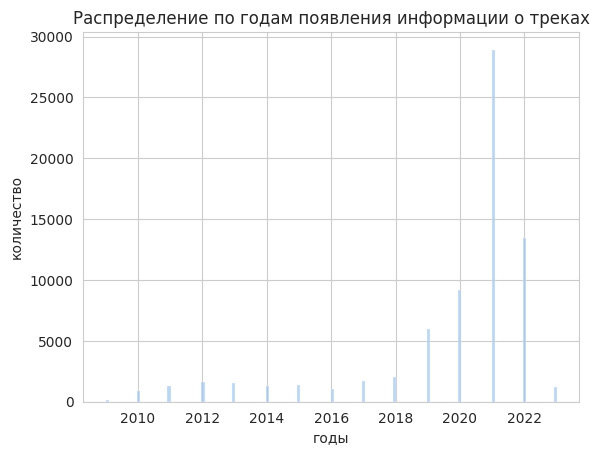

In [ ]:
sns.histplot(data.dttm.dt.year)
plt.title('Распределение по годам появления информации о треках')
plt.xlabel('годы')
plt.ylabel('количество');

- все имеющиеся треки были "залиты" на ресурс в одно и то же время с течении 7 минут
- теперь посмотрим на распределение целевой переменной:

In [ ]:
data.track_remake_type.value_counts().to_frame(name='Итого:')

,Итого:
COVER,67304
ORIGINAL,4293


In [ ]:
data[data.track_remake_type=='COVER'].shape[0]\
    - data[data.track_remake_type=='COVER'].original_track_id.isna().sum()

528

- основная информация об оригинальных треках в данных, помеченых как кавер отсутствует, имеется только 528 записей
- теперь посмотрим на распространение некоторых данных относительно уникальных ID треков:

In [ ]:
data.groupby('original_track_id')['track_id'].nunique().sort_values(ascending=False)\
    .to_frame(name='Итого:')

,Итого:
original_track_id,
f3e5e9db509f9b6f6d93b9c38e4e1324,38
17a163f6ab3de102b49599f5577866fc,32
deb9b9598176a0bab1212d430b10bd04,31
53a04991308c2cc9179fdd401fea83a3,30
9050384cce6c221c39d6e25d02561612,25
...,...
544382d3942c949b6db721c9c456c1e1,1
546690f484841934a22f76df503635b2,1
5494107d159a1e4d498e3eb638494401,1


In [ ]:
data.groupby('original_track_id')['title'].nunique().sort_values(ascending=False).to_frame(name='Итого:')

,Итого:
original_track_id,
cfcd208495d565ef66e7dff9f98764da,17
deb9b9598176a0bab1212d430b10bd04,9
8e0235cf2a39eacc4c78885ca7dd4de3,6
684c7772ff3e8ec3a8ffe317b791afd9,4
f3e5e9db509f9b6f6d93b9c38e4e1324,3
...,...
5404900983bd6b8b8ded87d0a52ff8f2,1
540527a74bc5ef464977bb11070c5201,1
54119f4a41c7a133c0d2199de57ad3a8,1


In [ ]:
data.groupby('title')['track_id'].nunique().sort_values(ascending=False).to_frame(name='Итого:')

,Итого:
title,
Morena,81
Smooth Criminal,75
Rolê,72
Wicked Game,67
Esquema Preferido,66
...,...
I Will Try To Fix You,1
I Will Wait For You,1
I Will Whisper Your Name,1


- мы можем сделать вывод, что немногим имеющимся у нас данным об ID оригинальных треках, соответствует разное количество уникальных ID треков(но подавляющие количество имеет соответствие только с единственным ID), точно такая же ситуация и с названиями треков.

In [ ]:
data.language.value_counts().to_frame(name='Итого:')

,Итого:
EN,15194
ES,1746
RU,1545
IT,907
HI,285
...,...
SE,1
LV,1
AV,1
IU,1


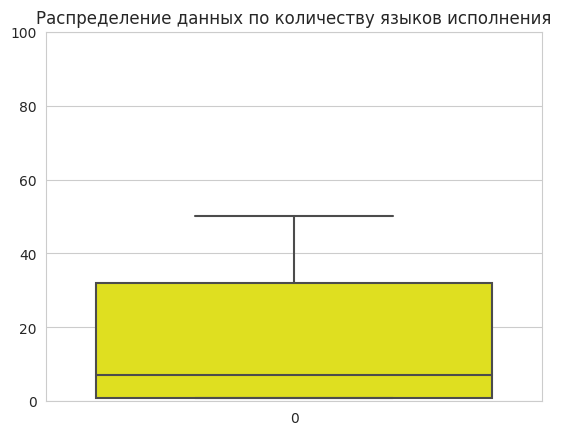

In [ ]:
sns.boxplot(data.language.value_counts(), color='yellow')
plt.ylim(0, 100)
plt.title('Распределение данных по количеству языков исполнения')
plt.show()

In [ ]:
data.genres.value_counts().to_frame(name='Итого:')

,Итого:
folk,21282
pop,14773
rock,6204
alternative,3569
rap,2497
...,...
"spoken,pop",1
"spoken,rnb",1
"folk,esa",1
"dance,relax",1


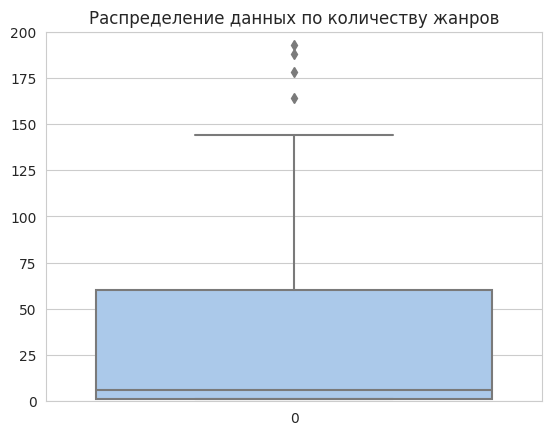

In [ ]:
sns.boxplot(data.genres.value_counts())
plt.ylim(0, 200)
plt.title('Распределение данных по количеству жанров')
plt.show()

In [ ]:
data.duration.value_counts().to_frame(name='Итого:')

,Итого:
0.0,369
28000.0,121
30000.0,86
180000.0,75
192000.0,70
...,...
405570.0,1
117440.0,1
199430.0,1
118620.0,1


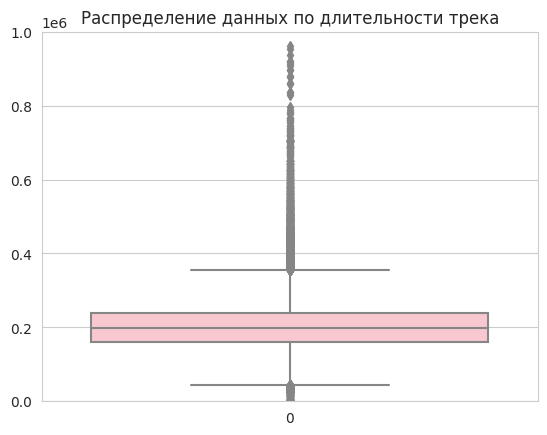

In [ ]:
sns.boxplot(data.duration, color='pink')
plt.ylim(0, 1000000)
plt.title('Распределение данных по длительности трека')
plt.show()

- мы имеем: треки исполнены на 85 языках(большей частью на английском), в 229 жанрах(многие из которых являюся смешанными), также имеем 23581 вариацию длительности, в столбце с длительностью трека есть 369 строк со значением 0:

In [ ]:
data[data.duration==0].sample(5)

,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration
6029,None,88fe124498fcc29e160a568d5bbc39cf,COVER,2013-11-20 13:32:25,I Saw Red,None,USESK0601394,rock,0.0
29948,None,d2436a874b0469c28d294312a6a13cc1,COVER,2021-01-25 02:41:05,Eu To Solteiro,None,QZ5AB2115799,folk,0.0
14244,None,5438bba667684071d6c2e13148a0d1dd,COVER,2019-02-01 04:57:41,Ek Veera Aai,None,INUM70900025,pop,0.0
68830,None,b69be2cc7dc2973e90ce4ca295abf308,COVER,2022-07-27 13:41:01,Paisaje de Catamarca - Zamba del Grillo,None,QZNJY2150770,"vocal,classical",0.0
14277,None,58c2d8edd13544b0dfb60f5ed25b75a7,COVER,2019-02-01 04:57:41,Kata Rute Kunala,MR,INUM70900094,pop,0.0


- кроме столбца с длительностью эти данные могут иметь полезную информацию, и поэтому пока не буду их удалять, и заменю ноли на медианные значения по категории(возможно в будующем их нужно будет удалить)

In [ ]:
data[data.duration==0].duration.replace(0.0, data.duration.median(), inplace=True)

In [ ]:
lyrics.groupby('track_id')['text'].nunique().sort_values(ascending=False).to_frame(name='Итого:')

,Итого:
track_id,
adc126c946551da4e1784e716b77992e,10
f5da21fe563623eab22581b287412a97,8
f0f429d03fdd19f08ff60e889e32aae2,8
480df87b3a62c2f84876f824d068500e,7
86afaff232b86d6ae5d6c9a1f967549f,7
...,...
57f2911668376cc555f7b7d7a5498b33,1
57f7d30f6cb933d863c756b9e62e7301,1
57f8f5c2387a5e952a1a71f936b46c42,1


In [ ]:
data.groupby('isrc')['track_remake_type'].unique().value_counts()

[COVER]              66916
[ORIGINAL]            4196
[COVER, ORIGINAL]        1
[COVER, ORIGINAL]        1
[COVER, ORIGINAL]        1
Name: track_remake_type, dtype: int64

- так код isrc является уникальным и определить его точное отношение к тем или иным данным пока не предоставляется возможным, уберу дубликаты по этому признаку(потери составят менее 1%)

In [ ]:
data.drop_duplicates(subset='isrc', inplace=True)

In [ ]:
data.dropna(subset='isrc', inplace=True)

In [ ]:
data.shape

(71115, 9)

In [ ]:
data[data.language.isna()].isrc

6        USGR19900418
29       USFI87500052
38       USC4R0405777
61       USGR10500142
62       USGR10500138
             ...     
71590    RUAGT2312926
71591    RUAGT2312927
71592    RUAGT2312928
71595    SMRUS0076417
71596    DGA0M2316512
Name: isrc, Length: 49396, dtype: object

- попробуем добавить признак из даты

In [ ]:
data['year'] = data.dttm.dt.year.astype(str)

- преобразуем столбец с длительностью трека: переведем его в секунды

In [ ]:
data.duration = round(data.duration/1000, 2)

- так как в уникальном коде isrc данные "зашиты" следующим образом:
  - первые два символа страна регистрации трека,
  - следующие три символа - правообладатель трека(исполнитель/лейбл),
  - следующие два символа - год релиза трека,
  - последние пять символов - номер трека,

разобьем его на эти составляющие и вынесем в отдельные признаки

In [ ]:
data['country'] = [x[0:2] for x in data.isrc]
data['owner'] = [x[2:5] for x in data.isrc]
data['realis_year'] = [x[5:7] for x in data.isrc]
data.realis_year.replace('5-', '05', inplace=True)
data['serial_num'] = [x[7:12] for x in data.isrc]

In [ ]:
data.serial_num.replace('12-05', '12005', inplace=True)

In [ ]:
data.serial_num = data.serial_num.astype(int)

- теперь приведем столбец с годом релиза к полному формату

In [ ]:
_00 = ('20' + data[data['realis_year'].str.startswith('0')].realis_year).reset_index()
_10 = ('20' + data[data['realis_year'].str.startswith('1')].realis_year).reset_index()
_20 = ('20' + data[data['realis_year'].str.startswith('2')].realis_year).reset_index()
_30 = ('19' + data[data['realis_year'].str.startswith('3')].realis_year).reset_index()
_40 = ('19' + data[data['realis_year'].str.startswith('4')].realis_year).reset_index()
_50 = ('19' + data[data['realis_year'].str.startswith('5')].realis_year).reset_index()
_60 = ('19' + data[data['realis_year'].str.startswith('6')].realis_year).reset_index()
_70 = ('19' + data[data['realis_year'].str.startswith('7')].realis_year).reset_index()
_80 = ('19' + data[data['realis_year'].str.startswith('8')].realis_year).reset_index()
_90 = ('19' + data[data['realis_year'].str.startswith('9')].realis_year).reset_index()


In [ ]:
temp = pd.concat([_00, _10, _20, _30, _40, _50, _60, _70, _80, _90]).sort_values(by='index')

In [ ]:
temp.index = temp['index']
temp.drop('index', axis=1, inplace=True)
data.realis_year = temp.astype(int)

In [ ]:
data[['year', 'realis_year', 'track_remake_type']]

,year,realis_year,track_remake_type
0,2009,1969,ORIGINAL
1,2009,1969,ORIGINAL
2,2009,2004,ORIGINAL
3,2009,2007,ORIGINAL
4,2009,2009,COVER
...,...,...,...
71592,2023,2023,ORIGINAL
71593,2023,2023,COVER
71594,2023,2023,COVER
71595,2023,2000,ORIGINAL


In [ ]:
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

- судя по вышеуказанной информации в имеющемся у нас признаке год - не полная информация(год релиза меньше года в признаке, но трек имеет отметку как оригинал), поэтому я необходимо рассмотреть актуален ли признак year в итоговом наборе

## **Создание Датасета на основе текстов песен**

Для выработки качественной системы предложений необходимо использовать так же тексты песен, поэтомы приняли решение создать датасет, основывающийся на этих данных. Для того, чтобы использовать тексты в полной мере их необходимо сначала предобработать.

In [ ]:
df_text = lyrics.copy()

### Очистка текстов от символов, приведение к нижнему регистру

In [ ]:
# Функция для очистки текста от лишних символов
def clean_text(text):
    # приводим текст к нижнему регистру
    text = text.lower()
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    # удаляем лишние символы
    text = re.sub(regular, '', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # возвращаем очищенные данные
    return text

In [ ]:
# создаем список для хранения очищенных данных
cleaned_text = []
# для каждого текста трека из столбца text
for text in df_text['text']:
    # очищаем данные
    text = clean_text(text)
    # добавляем очищенные данные в список cleaned_text
    cleaned_text.append(text)
# записываем очищенные данные в новую колонку 'cleaned_text'
df_text['cleaned_text'] = cleaned_text

In [ ]:
df_text.head()

,text,track_id,cleaned_text
0,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd,живу сейчас обломами обломками не той любви по...
1,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8,tell me your fable a fable tell me your fable ...
2,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741,you're ashamed about all your fears and doubts...
3,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1,you're ashamed about all your fears and doubts...
4,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659,you showed him all the best of you but i'm afr...


In [ ]:
df_text.duplicated().sum()

0

In [ ]:
df_text['track_id'].value_counts()

adc126c946551da4e1784e716b77992e    10
f0f429d03fdd19f08ff60e889e32aae2     8
f5da21fe563623eab22581b287412a97     8
8a43257f07dd1fcfa6cfb92d0b7cb703     7
86afaff232b86d6ae5d6c9a1f967549f     7
                                    ..
e44404ec63a98c94f176e2c52fee5a06     1
e4b1d2b68d16307d9b58a59510309a65     1
c089f8d42dd6815e3be20869a1f98a93     1
a8d791db22ff2a9267ce5f24cbfe145a     1
c860754a50dac664d847bca85e6897f4     1
Name: track_id, Length: 10277, dtype: int64

Я предполагаю, что можно сравнить тексты среди одинаковых track_id и если они проходят порог similarity_threshold, то можно оставить только самый длинный текст, а остальные удалить.

In [ ]:
def filter_longest_simmilar_text(df, text_column, track_id_column, similarity_threshold=0.1):
    # Создадим словарь, чтобы хранить самые длинные тексты для каждого track_id
    longest_texts = {}

    for i, row in df.iterrows():
        track_id = row[track_id_column]
        text = row[text_column]

        if track_id not in longest_texts:
            longest_texts[track_id] = (text, len(text))
        else:
            existing_text, existing_text_length = longest_texts[track_id]

            # Сравниваем существующий текст с текущим текстом
            similarity = difflib.SequenceMatcher(None, existing_text, text).ratio()

            if similarity >= similarity_threshold and len(text) > existing_text_length:
                # Если текущий текст сходится с существующим и длиннее, заменяем его
                longest_texts[track_id] = (text, len(text))

    # Создаем новый DataFrame с самыми длинными текстами
    filtered_df = pd.DataFrame(columns=df.columns)

    for i, row in df.iterrows():
        track_id = row[track_id_column]

        if track_id in longest_texts:
            text, _ = longest_texts[track_id]

            if row[text_column] == text:
                filtered_df = filtered_df.append(row)

    return filtered_df

In [ ]:
df_text = filter_longest_simmilar_text(df_text, 'cleaned_text', 'track_id', similarity_threshold=0.1)

In [ ]:
df_text.shape

(10310, 3)

In [ ]:
df_text['track_id'].value_counts()

0021519c8533f1116591948bbb349aef    2
6a52d90302fa89ee5585ef1078693718    2
3716307d2ede6813c2e7511b2cb957cd    2
17df7b240af924f49e8d8cecb1ec02a5    2
2398589f134c0086c4f33519285b2b35    2
                                   ..
eb8bfa552c2200a881e741bb3d832579    1
f20c6eeff1909b58f4f7c878d92f9eb3    1
5fa29e879d4cf35dca31752fb5280ae0    1
407bdd9443aebfc1e59d2bece259d688    1
c860754a50dac664d847bca85e6897f4    1
Name: track_id, Length: 10277, dtype: int64

In [ ]:
df_text.loc[(df_text['track_id'] == '17df7b240af924f49e8d8cecb1ec02a5')]

,text,track_id,cleaned_text
9923,"Decisions as I go, to anywhere I flow\nSometim...",17df7b240af924f49e8d8cecb1ec02a5,decisions as i go to anywhere i flow sometimes...
9937,"Decisions as I go, to anywhere I flow\nSometim...",17df7b240af924f49e8d8cecb1ec02a5,decisions as i go to anywhere i flow sometimes...


Сравнила несколько получившихся дублей, не прошедших порог. Они, однако относятся к одной песне, поэтому выберу из них опять же самый длинный текст. Колонку с исходными текстами сразу удалю.

In [ ]:
def filter_longest_text(df):
    # Создаем словарь для отслеживания самого длинного текста по каждому track_id
    longest_text_dict = {}

    for i, row in df.iterrows():
        track_id = row['track_id']
        text = row['cleaned_text']

        # Проверяем, существует ли запись для данного track_id в словаре
        if track_id in longest_text_dict:
            # Сравниваем длину текущего текста с длиной текста, сохраненного в словаре
            if len(text) > len(longest_text_dict[track_id]):
                # Если текущий текст длиннее, обновляем его в словаре
                longest_text_dict[track_id] = text
        else:
            # Если записи для данного track_id еще нет, добавляем его в словарь
            longest_text_dict[track_id] = text

    # Создаем новый DataFrame только с самыми длинными текстами
    longest_texts = pd.DataFrame(longest_text_dict.items(), columns=['track_id', 'cleaned_text'])

    return longest_texts

In [ ]:
df_text = filter_longest_text(df_text)

In [ ]:
df_text.shape

(10277, 2)

In [ ]:
df_text['track_id'].value_counts()

1c4b1230f937e4c548ff732523214dcd    1
f98455b46002a09d78d3d59f7fe599dc    1
6ad6e1ac1071bb345ee66d6d0ce7a656    1
8fa041a4f20fab014de0c2f5ff3fabb8    1
551a566a5d2ec73064d232e8a8a99038    1
                                   ..
1c6b85acb347383e39248f40bc250a17    1
271de6c144f82ecf7bda9d68429f4baa    1
836db3ef5dfd8e0ecdceb402127b43e5    1
0d7907ff9a88d87b1f1153e03305b511    1
c860754a50dac664d847bca85e6897f4    1
Name: track_id, Length: 10277, dtype: int64

In [ ]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10277 entries, 0 to 10276
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   track_id      10277 non-null  object
 1   cleaned_text  10277 non-null  object
dtypes: object(2)
memory usage: 160.7+ KB


### Объединени датасетов data и тексты

In [ ]:
df_text1 = df_text.merge(data, on='track_id')
df_text1.shape

(9974, 15)

In [ ]:
df_text1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           9974 non-null   object        
 1   cleaned_text       9974 non-null   object        
 2   original_track_id  2992 non-null   object        
 3   track_remake_type  9974 non-null   object        
 4   dttm               9974 non-null   datetime64[ns]
 5   title              9974 non-null   object        
 6   language           6222 non-null   object        
 7   isrc               9974 non-null   object        
 8   genres             9974 non-null   object        
 9   duration           9974 non-null   float64       
 10  year               9974 non-null   object        
 11  country            9974 non-null   object        
 12  owner              9974 non-null   object        
 13  realis_year        9974 non-null   int64         
 14  serial_n

Объединение решили произвести по совпадению данных. К сожалению о некоторых треках с тексами в датасете data ниформации нет, поэтому рабочий датасет содержит 9974 строки. Пропуски присутствуют только в колонках язык и original_track_id

In [ ]:
df_text = df_text1.copy()

### Обработка названий треков

Для работы с названиями треков нужно привести их нижнему регистру и очистить от знаков препинания

In [ ]:
# создаем список для хранения очищенных данных
cleaned_title = []
# для каждого назвавния трека из столбца title
for text in df_text['title']:
    # очищаем данные
    text = clean_text(text)
    # добавляем очищенные данные в список cleaned_title
    cleaned_title.append(text)
# записываем очищенные данные в новую колонку 'cleaned_title'
df_text['cleaned_title'] = cleaned_title

In [ ]:
df_text.head()

,track_id,cleaned_text,original_track_id,track_remake_type,dttm,title,language,isrc,genres,duration,year,country,owner,realis_year,serial_num,cleaned_title
0,1c4b1230f937e4c548ff732523214dcd,живу сейчас обломами обломками не той любви по...,1c4b1230f937e4c548ff732523214dcd,ORIGINAL,2018-09-26 02:24:21,Сарафан,None,AEA0D1860569,bard,140.00,2018,AE,A0D,2018,60569,сарафан
1,0faea89b0d7d6235b5b74def72511bd8,tell me your fable a fable tell me your fable ...,None,COVER,2021-08-04 13:08:25,Children,None,QZS672199805,electronics,214.59,2021,QZ,S67,2021,99805,children
2,9c6dc41d5ccd9968d07f055da5d8f741,you're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741,ORIGINAL,2010-05-20 05:00:14,Briane,None,USUM71006645,rock,317.91,2010,US,UM7,2010,6645,briane
3,bfd04a73e9cffdf0e282c92219a86ea1,you're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1,ORIGINAL,2014-09-23 12:07:56,Briane,None,USM951100211,rock,317.86,2014,US,M95,2011,211,briane
4,8d70930d09cd239c948408d1317d8659,you showed him all the best of you but i'm afr...,8d70930d09cd239c948408d1317d8659,ORIGINAL,2010-05-20 05:00:14,Broken Angel,None,USUM71006638,rock,321.28,2010,US,UM7,2010,6638,broken angel


In [ ]:
df_text.isna().sum()

track_id                0
cleaned_text            0
original_track_id    6982
track_remake_type       0
dttm                    0
title                   0
language             3752
isrc                    0
genres                  0
duration                0
year                    0
country                 0
owner                   0
realis_year             0
serial_num              0
cleaned_title           0
dtype: int64

In [ ]:
df_text.groupby(['cleaned_title'])['cleaned_text'].count().sort_values()

cleaned_title
1 0 0 1 1                                          1
the fever                                          1
the evil within 2 ordinary world trailer music     1
the end of evangelion komm süsser tod piano        1
the district sleeps alone tonight                  1
                                                  ..
smooth criminal                                   19
smells like teen spirit                           21
stand by me                                       22
toxic                                             27
wicked game                                       38
Name: cleaned_text, Length: 7488, dtype: int64

Возьму для примера 3 трека, имеющие нескольно вариантов текста - wicked game, toxic и temporary с одним вариантом  

In [ ]:
sample = df_text.loc[(df_text['cleaned_title'] == 'wicked game') |
                     (df_text['cleaned_title'] == 'toxic') |
                     (df_text['cleaned_title'] =='temporary')
                     ]
sample.head()

,track_id,cleaned_text,original_track_id,track_remake_type,dttm,title,language,isrc,genres,duration,year,country,owner,realis_year,serial_num,cleaned_title
187,245ab5617e7621d6b5bc7c9a2cd47271,thoughts spin hard to breathe we are temporary...,245ab5617e7621d6b5bc7c9a2cd47271,ORIGINAL,2021-04-12 15:52:37,Temporary,EN,QZFYY2194572,electronics,124.81,2021,QZ,FYY,2021,94572,temporary
289,6c56a114f6f1608c666cd67cd86042de,no one like no one like i never thought i'd be...,f3e5e9db509f9b6f6d93b9c38e4e1324,COVER,2019-06-07 21:49:18,Wicked Game,None,TCADW1839732,rnb,156.29,2019,TC,ADW,2018,39732,wicked game
391,755f08335f8436fafd3806fe9c5b867a,the world was on fire and no one could save me...,f3e5e9db509f9b6f6d93b9c38e4e1324,COVER,2021-01-14 21:00:00,Wicked Game,EN,GBKPL1668098,alternative,284.80,2021,GB,KPL,2016,68098,wicked game
584,9fb19ba70fc34f143c734d5dd8ac8e26,baby can't you see i'm calling a girl like you...,53a04991308c2cc9179fdd401fea83a3,COVER,2018-12-14 21:00:00,Toxic,EN,GBKPL1776594,pop,174.22,2018,GB,KPL,2017,76594,toxic
835,abf209547f77844456526934076358f2,the world was on fire and no one could save me...,f3e5e9db509f9b6f6d93b9c38e4e1324,COVER,2017-02-11 20:36:21,Wicked Game,EN,DEN061600356,electronics,215.20,2017,DE,N06,2016,356,wicked game


In [ ]:
sample.groupby(['cleaned_title', 'track_remake_type', 'language', 'realis_year'])['title'].count()

cleaned_title  track_remake_type  language  realis_year
temporary      ORIGINAL           EN        2021           1
toxic          COVER              EN        2006           1
                                            2007           2
                                            2008           2
                                            2009           1
                                            2010           1
                                            2012           1
                                            2014           1
                                            2015           1
                                            2016           1
                                            2017           5
                                            2018           2
                                            2020           1
                                            2021           1
               ORIGINAL           EN        2021           1
wicked game    COVER         

- У трека wicked game отмечен 1 оригинал с датой релиза 2006 год, при этом самый ранний трек из каверов датирован 1997 годом.
- У трека toxic оригиналом отмечен трек с релизом в 2021 году, каверы все имеют более ранний год релиза

### Обработка пропусков в языке

Приведу все значения метки языка к нижнему регистру, чтобы избежать дублей

In [ ]:
df_text['language'] = df_text['language'].str.lower()

In [ ]:
df_text['language'].unique()

array([None, 'es', 'en', 'pt', 'ru', 'uk', 'it', 'ja', 'da', 'fr', 'sw',
       'de', 'no', 'ro', 'ms', 'hi', 'th', 'as', 'id', 'ar', 'tr', 'sr',
       'vi', 'ia', 'et', 'pa', 'tl', 'pl', 'ta', 'hu', 'ml', 'af', 'sv',
       'el', 'he', 'az', 'ha', 'si', 'kn', 'sk', 'ie', 'zh', 'la', 'sq',
       'nl', 'te', 'uz'], dtype=object)

Необходимо заполнить пропуски в языке исполнения. Воспользуюсь для этого библиотекой langtest, которая умеет определять 55 языков.

In [ ]:
!pip install langdetect

In [ ]:
from langdetect import detect

def fill_language_column(df):
    for index, row in df.iterrows():
        text = row['cleaned_text']
        language = row['language']

        if pd.isna(language):  # Проверяем, есть ли пропуск в колонке 'language'
            try:
                detected_language = detect(text)
                df.at[index, 'language'] = detected_language
            except:
                df.at[index, 'language'] = 'unknown'  # Если не удалось определить язык, можно использовать 'unknown', как значение по умолчанию
    return df

In [ ]:
%%time
df_text = fill_language_column(df_text)

CPU times: user 30.7 s, sys: 207 ms, total: 30.9 s
Wall time: 37.4 s


In [ ]:
df_text.loc[df_text['language'] == 'unknown'].value_counts().sum()

0

In [ ]:
df_text['language'].unique()

array(['ru', 'en', 'es', 'pt', 'uk', 'fr', 'it', 'ja', 'cy', 'cs', 'da',
       'pa', 'sw', 'de', 'no', 'ro', 'ca', 'hi', 'ms', 'hr', 'bg', 'th',
       'pl', 'as', 'so', 'tl', 'id', 'ar', 'tr', 'sr', 'vi', 'sv', 'ia',
       'bn', 'et', 'ta', 'hu', 'ml', 'el', 'af', 'fi', 'he', 'az', 'ha',
       'si', 'kn', 'sk', 'sq', 'ie', 'ko', 'te', 'zh', 'zh-cn', 'la',
       'nl', 'uz'], dtype=object)

In [ ]:
df_text['language'].nunique()

56

***Выводы по процессу обработки имеющихся признаков и созданию новых:***
- нами была проведена обработка всех имеющихся текстовых признаков:
  - приведение к единому регистру, удаление "шумных данных"
  - разделение списка с жанрами треков на составляющие, "очистка" и приведение к общему виду
  - удаление дубликатов в текстах
  - восстановление пропусков в признаке с языком исполнения при помощи библиотеки langtest
- создание новых признаков из уникального isrc кода(страна релиза, год релиза, правообладатель трека, серийный номер)

### Анализ полученного датасета, основанного на текстах

In [ ]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           9974 non-null   object        
 1   cleaned_text       9974 non-null   object        
 2   original_track_id  2992 non-null   object        
 3   track_remake_type  9974 non-null   object        
 4   dttm               9974 non-null   datetime64[ns]
 5   title              9974 non-null   object        
 6   language           9974 non-null   object        
 7   isrc               9974 non-null   object        
 8   genres             9974 non-null   object        
 9   duration           9974 non-null   float64       
 10  year               9974 non-null   object        
 11  country            9974 non-null   object        
 12  owner              9974 non-null   object        
 13  realis_year        9974 non-null   int64         
 14  serial_n

In [ ]:
df_text.isna().sum()

track_id                0
cleaned_text            0
original_track_id    6982
track_remake_type       0
dttm                    0
title                   0
language                0
isrc                    0
genres                  0
duration                0
year                    0
country                 0
owner                   0
realis_year             0
serial_num              0
cleaned_title           0
dtype: int64

In [ ]:
df_text.groupby(['track_remake_type'])['original_track_id'].count()

track_remake_type
COVER        324
ORIGINAL    2668
Name: original_track_id, dtype: int64

Так как в колонке original_track_id очень много пропусков и информации для каверов заполнено только в 324 треках, эту колонку приняли решение удалить.

In [ ]:
df_text.drop('original_track_id', axis=1, inplace=True)

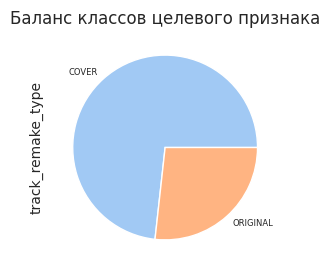

In [ ]:
df_text['track_remake_type'].value_counts().plot(kind='pie', figsize=(3, 3), labeldistance=1.1,
               pctdistance=0.95, fontsize=6, title='Баланс классов целевого признака')
plt.show()

In [ ]:
df_text.columns

Index(['track_id', 'cleaned_text', 'track_remake_type', 'dttm', 'title',
       'language', 'isrc', 'genres', 'duration', 'year', 'country', 'owner',
       'realis_year', 'serial_num', 'cleaned_title'],
      dtype='object')

Удалю колонки, которые не буду использовать для обучения. Название - оставлю обработанное

In [ ]:
df_text.drop(['title', 'dttm', 'serial_num'], axis=1, inplace=True)
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           9974 non-null   object 
 1   cleaned_text       9974 non-null   object 
 2   track_remake_type  9974 non-null   object 
 3   language           9974 non-null   object 
 4   isrc               9974 non-null   object 
 5   genres             9974 non-null   object 
 6   duration           9974 non-null   float64
 7   year               9974 non-null   object 
 8   country            9974 non-null   object 
 9   owner              9974 non-null   object 
 10  realis_year        9974 non-null   int64  
 11  cleaned_title      9974 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.2+ MB


**Выводы:**
- был удален столбец original-id, который из-за наличия многочисленных пропусков не может помочь в анализе имеющихся признаков, и по сути дублирует целевую переменную
- сделан вывод о наличии дисбаланса классов целевой переменной в сторону нулевого класса(класс отсутствия оригинального трека)

## Группировка

Есть предположение, что могут встречаться треки с одинаковыми названиями, но с разными текстами - соответственно, не являющиеся каверами.
Решили сгруппировать по тексту треки, внутри кластера треков с одинаковыми названиями.

In [ ]:
sample = df_text.loc[(df_text['cleaned_title'] == 'wicked game') |
                     (df_text['cleaned_title'] == 'toxic') |
                     (df_text['cleaned_title'] =='temporary')
                     ]
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 187 to 9730
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           66 non-null     object 
 1   cleaned_text       66 non-null     object 
 2   track_remake_type  66 non-null     object 
 3   language           66 non-null     object 
 4   isrc               66 non-null     object 
 5   genres             66 non-null     object 
 6   duration           66 non-null     float64
 7   year               66 non-null     object 
 8   country            66 non-null     object 
 9   owner              66 non-null     object 
 10  realis_year        66 non-null     int64  
 11  cleaned_title      66 non-null     object 
dtypes: float64(1), int64(1), object(10)
memory usage: 6.7+ KB


In [ ]:
def compare_and_group_texts(df, song_column, text_column, similarity_threshold=0.1):
    # Создаем словарь, чтобы отображать каждый текст в его группу
    text_to_group = {}
    group_counter = 1  # Инициализируем счетчик групп

    for group_name, group_df in df.groupby(song_column):
        for i, row in group_df.iterrows():
            text1 = row[text_column]
            # Если текст уже присвоен группе, пропускаем его
            if text1 in text_to_group:
                continue

            # Создаем новую группу для текущего текста
            text_to_group[text1] = group_counter
            group_counter += 1

            # Сравниваем текущий текст со всеми остальными текстами внутри текущей группы
            for j, row2 in group_df.iterrows():
                text2 = row2[text_column]
                if text2 in text_to_group:
                    continue
                similarity = difflib.SequenceMatcher(None, text1, text2).ratio()

                # Если схожесть больше заданного порога, присваиваем им одну и ту же группу
                if similarity >= similarity_threshold:
                    text_to_group[text2] = text_to_group[text1]

    # Создаем новую колонку 'Group' с номерами групп
    df['group'] = [text_to_group[row[text_column]] for i, row in df.iterrows()]

    return df

In [ ]:
# Применяем функцию к тестам треков
grouped_sample = compare_and_group_texts(sample, song_column='cleaned_title', text_column='cleaned_text', similarity_threshold=0.1)

In [ ]:
grouped_sample.head()

,track_id,cleaned_text,track_remake_type,language,isrc,genres,duration,year,country,owner,realis_year,cleaned_title,group
187,245ab5617e7621d6b5bc7c9a2cd47271,thoughts spin hard to breathe we are temporary...,ORIGINAL,en,QZFYY2194572,electronics,124.81,2021,QZ,FYY,2021,temporary,1
289,6c56a114f6f1608c666cd67cd86042de,no one like no one like i never thought i'd be...,COVER,en,TCADW1839732,rnb,156.29,2019,TC,ADW,2018,wicked game,6
391,755f08335f8436fafd3806fe9c5b867a,the world was on fire and no one could save me...,COVER,en,GBKPL1668098,alternative,284.80,2021,GB,KPL,2016,wicked game,7
584,9fb19ba70fc34f143c734d5dd8ac8e26,baby can't you see i'm calling a girl like you...,COVER,en,GBKPL1776594,pop,174.22,2018,GB,KPL,2017,toxic,2
835,abf209547f77844456526934076358f2,the world was on fire and no one could save me...,COVER,en,DEN061600356,electronics,215.20,2017,DE,N06,2016,wicked game,7


In [ ]:
grouped_sample['group'].value_counts()

7    27
2    24
6     9
1     1
3     1
8     1
9     1
4     1
5     1
Name: group, dtype: int64

In [ ]:
grouped_sample.groupby(['cleaned_title', 'group', 'year'])['cleaned_title'].count()

cleaned_title  group  year
temporary      1      2021    1
toxic          2      2014    2
                      2015    1
                      2016    1
                      2017    3
                      2018    5
                      2019    1
                      2020    6
                      2021    5
               3      2021    1
               4      2014    1
               5      2017    1
wicked game    6      2011    1
                      2018    1
                      2019    3
                      2021    4
               7      2010    1
                      2012    1
                      2013    2
                      2014    5
                      2016    1
                      2017    5
                      2018    2
                      2019    1
                      2020    2
                      2021    6
                      2022    1
               8      2021    1
               9      2018    1
Name: cleaned_title, dtype: int64

In [ ]:
grouped_sample.loc[grouped_sample['group'] == 3, 'cleaned_text']

7336    all my friends are toxic all ambitionless so r...
Name: cleaned_text, dtype: object

### Группировка всего датасета по текстам

In [ ]:
%%time
grouped_all_text_df = compare_and_group_texts(df_text, song_column='cleaned_title', text_column='cleaned_text', similarity_threshold=0.1)

CPU times: user 9.75 s, sys: 112 ms, total: 9.86 s
Wall time: 11.2 s


In [ ]:
grouped_all_text_df.groupby(['cleaned_title', 'group'])['cleaned_title'].count().sort_values()

cleaned_title                    group
1 0 0 1 1                        1         1
the loveliest night of the year  5311      1
the lost soul down               5310      1
the look                         5309      1
the lion                         5307      1
                                          ..
proud mary                       4210     15
stand by me                      4949     20
smells like teen spirit          4805     20
toxic                            5540     24
wicked game                      5997     27
Name: cleaned_title, Length: 8074, dtype: int64

In [ ]:
grouped_all_text_df['group'].max()

8043

In [ ]:
grouped_all_text_df['cleaned_title'].nunique()

7488

In [ ]:
# Группируем данные по номеру группы и году, подсчитываем количество
grouped = grouped_all_text_df.groupby(['group', 'realis_year']).size().reset_index(name='Count')

single_year_groups = (grouped.groupby('group')['Count'].count() == 1).sum()

print("Количество групп с одним треком:", single_year_groups)

multi_year_groups = (grouped.groupby('group')['Count'].count() > 1).sum()

print("Количество групп с несколькими треками:", multi_year_groups)

Количество групп с одним треком: 7232
Количество групп с несколькими треками: 811


In [ ]:
grouped_all_text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           9974 non-null   object 
 1   cleaned_text       9974 non-null   object 
 2   track_remake_type  9974 non-null   object 
 3   language           9974 non-null   object 
 4   isrc               9974 non-null   object 
 5   genres             9974 non-null   object 
 6   duration           9974 non-null   float64
 7   year               9974 non-null   object 
 8   country            9974 non-null   object 
 9   owner              9974 non-null   object 
 10  realis_year        9974 non-null   int64  
 11  cleaned_title      9974 non-null   object 
 12  group              9974 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 1.3+ MB


In [ ]:
grouped_all_text_df['year'] = grouped_all_text_df['year'].astype('int')

По итогам группировки треков по наименованию и тексту мы объединили треки с 7488 уникальными названиями (которые могли принадлежать разным композициям) в 8043 групп. Из них групп, куда попало несколько треков - 811.

## Использование Catboost на сгруппированных данных

Для машинного обучения решили использовать модель Catboost, так как она умеет работать с текстами без предварительного кодирования.

В качестве метрики выбрали была выбрана метрика ROC AUC - так как она дает более информативную оценку качества модели при имеющемся дисбалансе классов.

In [ ]:
data_cat = grouped_all_text_df.copy()
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           9974 non-null   object 
 1   cleaned_text       9974 non-null   object 
 2   track_remake_type  9974 non-null   object 
 3   language           9974 non-null   object 
 4   isrc               9974 non-null   object 
 5   genres             9974 non-null   object 
 6   duration           9974 non-null   float64
 7   year               9974 non-null   int64  
 8   country            9974 non-null   object 
 9   owner              9974 non-null   object 
 10  realis_year        9974 non-null   int64  
 11  cleaned_title      9974 non-null   object 
 12  group              9974 non-null   int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 1.3+ MB


In [ ]:
data_cat = data_cat.drop(['track_id', 'isrc'], axis=1)

- преобразуем целевой признак переведем его в бинарный формат, где ORIGINAL-1, COVER-0

In [ ]:
data_cat['track_remake_type'] = np.where(data_cat.track_remake_type=='ORIGINAL', 1, 0)

In [ ]:
target = data_cat['track_remake_type']
features = data_cat.drop('track_remake_type', axis=1)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(7979, 10) (1995, 10) (7979,) (1995,)


In [ ]:
features.columns

Index(['cleaned_text', 'language', 'genres', 'duration', 'year', 'country',
       'owner', 'realis_year', 'cleaned_title', 'group'],
      dtype='object')

In [ ]:
text_features = ['cleaned_title', 'cleaned_text']
cat_cols = ['genres', 'country', 'owner', 'language']
features_train[cat_cols] = features_train[cat_cols].astype('category')

Выделяем валидационный сет

In [ ]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(7979, 10) (1995, 10) (7979,) (1995,)


In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.2, random_state=12345, stratify=target_train)
print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)

(6383, 10) (1596, 10) (6383,) (1596,)


In [ ]:
%%time

cat = CatBoostClassifier(
    random_state=12345,
    eval_metric='AUC',
    iterations=1000,
    text_features=text_features,
    cat_features=cat_cols,
    verbose=50)

cat.fit(features_train, target_train, eval_set=(features_valid, target_valid))

print(f'Наилучший резйльтат: {cat.best_score_}')

Learning rate set to 0.05009
0:	test: 0.8223937	best: 0.8223937 (0)	total: 452ms	remaining: 7m 31s
50:	test: 0.9475963	best: 0.9475963 (50)	total: 21.1s	remaining: 6m 33s
100:	test: 0.9534300	best: 0.9534421 (98)	total: 34.2s	remaining: 5m 4s
150:	test: 0.9549706	best: 0.9549706 (150)	total: 47.2s	remaining: 4m 25s
200:	test: 0.9559603	best: 0.9559603 (200)	total: 1m	remaining: 3m 59s
250:	test: 0.9569379	best: 0.9569519 (244)	total: 1m 13s	remaining: 3m 38s
300:	test: 0.9576411	best: 0.9576912 (296)	total: 1m 26s	remaining: 3m 21s
350:	test: 0.9575089	best: 0.9578114 (310)	total: 1m 40s	remaining: 3m 6s
400:	test: 0.9575489	best: 0.9578114 (310)	total: 1m 54s	remaining: 2m 50s
450:	test: 0.9577212	best: 0.9578795 (426)	total: 2m 7s	remaining: 2m 34s
500:	test: 0.9583443	best: 0.9583443 (500)	total: 2m 20s	remaining: 2m 19s
550:	test: 0.9589292	best: 0.9589292 (550)	total: 2m 33s	remaining: 2m 5s
600:	test: 0.9592418	best: 0.9592598 (590)	total: 2m 46s	remaining: 1m 50s
650:	test: 0.95

In [ ]:
predictions = cat.predict(features_valid)
probabilities = cat.predict_proba(features_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(target_valid, probabilities)
accuracy = accuracy_score(target_valid, predictions)

In [ ]:
print('Метрика AUC ROC для модели на валидационных данных:', roc_auc)
print('Метрика Accuracy для модели на валидационных данных:', accuracy)

Метрика AUC ROC для модели на валидационных данных: 0.9594981999867779
Метрика Accuracy для модели на валидационных данных: 0.9097744360902256


#### Проверка на тестовых данных

In [ ]:
features_test[cat_cols] = features_test[cat_cols].astype('category')

In [ ]:
# Предсказание на тестовой выборке
predictions = cat.predict(features_test)
probabilities = cat.predict_proba(features_test)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(target_test, probabilities)
accuracy = accuracy_score(target_test, predictions)

In [ ]:
print('Метрика AUC ROC для модели на тестовых данных:', roc_auc)
print('Метрика Accuracy для модели на тестовых данных:', accuracy)

Метрика AUC ROC для модели на тестовых данных: 0.9500931843409292
Метрика Accuracy для модели на тестовых данных: 0.8947368421052632


In [ ]:
cm = confusion_matrix(target_test, predictions)

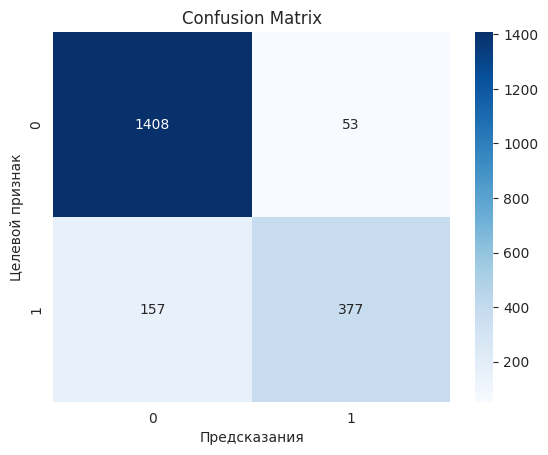

In [ ]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)

ax.set_xlabel('Предсказания')
ax.set_ylabel('Целевой признак')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

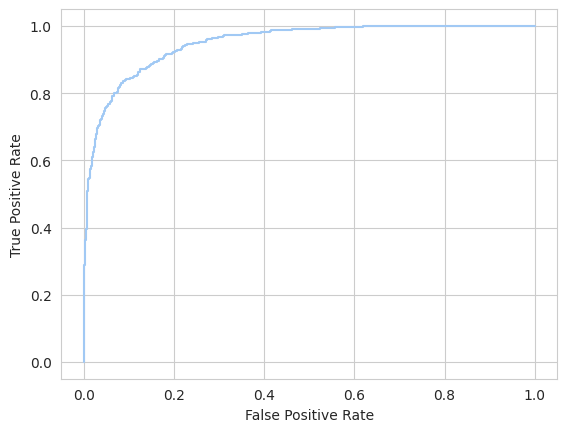

In [ ]:
fpr, tpr, _ = roc_curve(target_test, probabilities)

plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

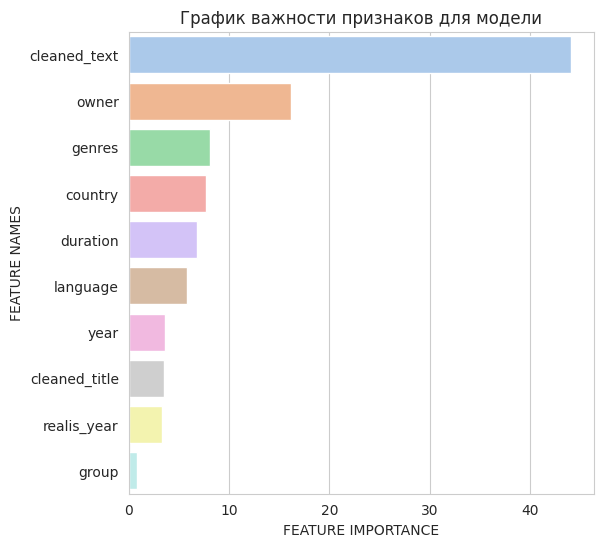

In [ ]:
def plot_feature_importance(importance,names):

    #Создание массива данных из feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Создание датафрейма и сортировка значений
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Создание графика
    plt.figure(figsize=(6,6))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title('График важности признаков для модели')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')



plot_feature_importance(cat.feature_importances_,features_train.columns)

- Итого: наша моделей неплохо предсказывает вероятнотность появления оригинального трека, и теперь мы перейдем к самому интересному:

## Разработка алгоритма предложений пользователю:

- ****Проектирование алгоритма предложения каверов пользователю на основании понравившегося ему трека:****
  - пользователь выбирает трек
  - на основании имеющегося у нас кластера, включающего в себя сам оригинал и его каверы мы можем предложить:
    - самый "новый" (максимальный год релиза) кавер
    - кавер на другом языке исполнения / ковер в инструментальном исполнении
    - кавер исполненный в другом жанре(из списка имеющихся в кластере)
    - оригинал, к понравившемуся каверу
    - каверы, к понравившемуся оригиналу
- Для реализации этого алгоритма необходимо:
  - разбить датасет на кластеры с выделением оригинала (уже сделано ранее при группировке датасета по трекам и текстам)
  - создать функцию, реализующую рекомендательный алгоритм

In [ ]:
data = grouped_all_text_df.copy()

In [ ]:
data.head()

,track_id,cleaned_text,track_remake_type,language,isrc,genres,duration,year,country,owner,realis_year,cleaned_title,group
0,1c4b1230f937e4c548ff732523214dcd,живу сейчас обломами обломками не той любви по...,ORIGINAL,ru,AEA0D1860569,bard,140.00,2018,AE,A0D,2018,сарафан,7561
1,0faea89b0d7d6235b5b74def72511bd8,tell me your fable a fable tell me your fable ...,COVER,en,QZS672199805,electronics,214.59,2021,QZ,S67,2021,children,951
2,9c6dc41d5ccd9968d07f055da5d8f741,you're ashamed about all your fears and doubts...,ORIGINAL,en,USUM71006645,rock,317.91,2010,US,UM7,2010,briane,751
3,bfd04a73e9cffdf0e282c92219a86ea1,you're ashamed about all your fears and doubts...,ORIGINAL,en,USM951100211,rock,317.86,2014,US,M95,2011,briane,751
4,8d70930d09cd239c948408d1317d8659,you showed him all the best of you but i'm afr...,ORIGINAL,en,USUM71006638,rock,321.28,2010,US,UM7,2010,broken angel,763


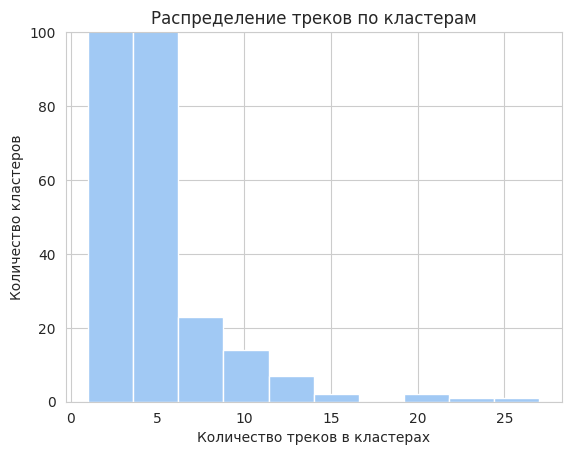

In [ ]:
plt.ylim(0, 100)
plt.xlabel('Количество треков в кластерах')
plt.ylabel('Количество кластеров')
plt.title('Распределение треков по кластерам')
data.groupby('group').isrc.nunique().hist();

In [ ]:
data.columns

Index(['track_id', 'cleaned_text', 'track_remake_type', 'language', 'isrc',
       'genres', 'duration', 'year', 'country', 'owner', 'realis_year',
       'cleaned_title', 'group'],
      dtype='object')

In [ ]:
def recommend_alternatives(isrc, prefer_original=True):
    # Найдите запись с заданным isrc
    selected_record = data[data['isrc'] == isrc]

    if selected_record.empty:
        return "Запись с заданным isrc не найдена"

    # Извлеките информацию из выбранной записи
    current_genre = selected_record['genres'].values[0]
    current_language = selected_record['language'].values[0]
    current_year = selected_record['realis_year'].values[0]
    cluster_group = selected_record['group'].values[0]
    is_original = selected_record['track_remake_type'].values[0]


    # Фильтруйте данные, чтобы найти альтернативы внутри того же кластера
    alternatives = data[
        (data['group'] == cluster_group) &
        (data['isrc'] != isrc)
    ]

   # Создайте словарь для хранения рекомендаций с указанием критерия
    recommendations = {
        'newer_year': [],
        'different_genre': [],
        'different_language': [],
        'same_original_status': [],
        'opposite_original_status': []
    }

    # Предлагайте альтернативы с тем же названием и более поздним годом
    newer_versions = alternatives[alternatives['realis_year'] == alternatives['realis_year'].max()]
    if not newer_versions.empty:
        recommendations['newer_year'] = newer_versions['isrc'].tolist()

    # Предлагайте альтернативы с разными жанрами
    different_genres = alternatives[alternatives['genres'] != current_genre]
    if not different_genres.empty:
        recommendations['different_genre'] = different_genres['isrc'].tolist()

    # Предлагайте альтернативы на других языках
    different_languages = alternatives[alternatives['language'] != current_language]
    if not different_languages.empty:
        recommendations['different_language'] = different_languages['isrc'].tolist()

    # Предлагайте альтернативы с тем же статусом "оригинал vs. кавер" и противоположным статусом
    same_original_status = alternatives[alternatives['track_remake_type'] == is_original]
    opposite_original_status = alternatives[alternatives['track_remake_type'] != is_original]
    if not same_original_status.empty:
        recommendations['same_original_status'] = same_original_status['isrc'].tolist()
    if not opposite_original_status.empty:
        recommendations['opposite_original_status'] = opposite_original_status['isrc'].tolist()


    if not any(recommendations.values()):
        return "Нет альтернатив для заданной записи"

    return recommendations

In [ ]:
# Пример использования функции
isrc_to_recommend = 'GBKPL1668098'
recommended_alternatives = recommend_alternatives(isrc_to_recommend)
if recommended_alternatives == "Нет альтернатив для заданной записи":
    print("Нет альтернатив для", isrc_to_recommend)
else:
    for criterion, isrc_list in recommended_alternatives.items():
        if isrc_list:
            print("Рекомендации по критерию", criterion, "для", isrc_to_recommend, ":", isrc_list)

Рекомендации по критерию newer_year для GBKPL1668098 : ['QZDA42299085']
Рекомендации по критерию different_genre для GBKPL1668098 : ['DEN061600356', 'DEN061600353', 'DEN061600310', 'USA2P2019488', 'UK4ZF2100453', 'ARF411400840', 'TCADJ1768115', 'TCABE1219309', 'ARF411900362', 'QM6N22037250', 'SMRUS0051191', 'NLA321700239', 'DELM40800334', 'QM42K2108382', 'USRE10601455', 'QZ8LD1975278', 'USRC12102818', 'NLA320784286', 'SEPQA1400981', 'FIBAR9900322', 'FIBAR9700075', 'QZDA42299085', 'GBCFB1300909', 'ARF412100162', 'ES5151300914', 'IEDNV1100040']
Рекомендации по критерию same_original_status для GBKPL1668098 : ['DEN061600356', 'DEN061600353', 'DEN061600310', 'USA2P2019488', 'UK4ZF2100453', 'ARF411400840', 'TCADJ1768115', 'TCABE1219309', 'ARF411900362', 'QM6N22037250', 'SMRUS0051191', 'NLA321700239', 'DELM40800334', 'QM42K2108382', 'QZ8LD1975278', 'USRC12102818', 'NLA320784286', 'SEPQA1400981', 'FIBAR9900322', 'FIBAR9700075', 'QZDA42299085', 'GBCFB1300909', 'ARF412100162', 'ES5151300914', '

***Выводы:***
- итого нашей командой была проведена работа по решению задачи классификации (определения класса оригинального трека из имеющегося набора оригиналов и каверов):
  - в ходе которой был проведен анализ и предобработка имеющегося датасета:
    - проведена работа с пропусками и дубликатами в данных, изменение типов данных
    - объединение данных в общий датасет
    - предобработка текстовых данных(текстов, названий, жанров треков);
  - были сгенерированы новые признаки из имеющегося уникального isrc кода
  - проведено обучение, валидация и тестирование модели-классификатора градиентного бустинга
  - спроектирован алгоритм рекомендательной системы по выбору треков для конечного пользователя продукта.
  